In [18]:
import networkx as nx
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from networkx.drawing.nx_pydot import graphviz_layout
from src.helper import draw_spring, load_graph_from_json, score_normalize
np.random.seed(123)

# 3 Network Centrality

As noted in Chapter 1, we can be interested in determining which nodes of a network are more important, more popular, or better connected. Network centrality measures aim to retrieve this information. 

There are a variety of network centrality measures, and although they overlap, they capture different ways in which a node may be regarded as central. Which centrality measure to use, depends on the research question one is interested in, on domain knowledge and sensitivity to context. 

The presentation that follows will present a range of centrality measures ranging from some very straightforward ones like degree centrality, to some more complex measures like Pagerank and HITS. The mathematics involved in this measures should be accessible to all readers (especially as ```numpy``` takes care of some otherwise intractable calculations).

It will also try to give you insight into some considerations that count when choosing which measure to focus on. This will involve comparing the results of different measures on simple networks. 

>Please note that it is not possible to compare the results of different centrality measures unless they are "normalized" first. For more on normalization please see Appendix 3. 



### 3.1 Degree and Degree Centrality

A first approach to finding which nodes are more central relies on degree. Degree is a property of nodes that records how many neighbors a node has. One would expect more central nodes to have a higher degree value than other nodes. It is possible to calculate Degree for every node and to subsequently rank the results from the one with most neighbors to the one with the least. This already provides with a simple, but reliable, centrality measure.
 
Degree provides for a discrete value. A node can have a degree score of 1, 5, 673, or any other value for that matter. Such a discrete value might not always provide insight. For instance, a degree score of 5 in a network of 6 nodes is very different from a degree score of 5 in a network of 200.000 nodes. For this reason the degree centrality measure typically contextualizes the degree score by divides the degree score by the number of nodes in the network minus 1.

Degree centrality is the simplest of all the centrality scores, and it considers only the direct number of connections you have. It does not consider things like indirect connections, or the relative importance of those who connect to you. So for those we will have to look at other measures.


For an easy illustration of how the calculation of degree and centrality measures looks in practice, we turn to an example of a 1970s karate club. This network arises from a sociological study of a karate club that would break up, with some students following the club's president and others the club instructor. What we are going to do here is to guess, using degree centrality, who might these two high profile club members be based on the number of friendships each karate club member has. For this, we can calculate the Degree scores for each individual node and subsequently rank the scores in a descending order. We suspect that the individuals with the highest Degree scores will be the instructor and the president.

<img src="images/shared/karate_generic.png"/>


In [19]:
g_karate = nx.karate_club_graph()
degree = nx.degree(g_karate)
nodeid = list(dict(degree).keys())
degscore = list(dict(degree).values())
centrality = nx.degree_centrality(g_karate)
centscore = list(dict(centrality).values())
resdf = pd.DataFrame({"node_id":nodeid, "degree":degscore, "deg_centrality":centscore})
resdf.set_index("node_id", inplace=True)
resdf.sort_values('degree', ascending=False)

,degree,deg_centrality
node_id,,
33,17,0.515152
0,16,0.484848
32,12,0.363636
2,10,0.303030
1,9,0.272727
3,6,0.181818
31,6,0.181818
23,5,0.151515
8,5,0.151515


This is in fact the case. The instructor is node 33 and the president is node 0.

We can do a similar exercise for a simplified network of some train stations in the Netherlands.

<img src="images/shared/trains_generic.png"/>


We can calculate the degree for each station. There are 20 train stations in this dataset. When we ask NetworkX to calculate the results, we can see that Utrecht has the highest degree (degree=12).

In [20]:
degree = nx.degree(g_trains)
nodeid = list(dict(degree).keys())
degscore = list(dict(degree).values())
centrality = nx.degree_centrality(g_trains)
centscore = list(dict(centrality).values())
resdf = pd.DataFrame({"node_id":nodeid, "degree":degscore, "deg_centrality":centscore})
resdf.set_index("node_id", inplace=True)
resdf.sort_values('degree', ascending=False)

NameError: name 'g_trains' is not defined

#### A) Undirected degree centrality

The idea of degree and degree centrality is straightforward enough. But now lets introduce some notation and try to do the calculations "by hand". This will help us when we move to slightly more complex metrics.

In terms of notation, the degree centrality of a node can be represented by the following formula:

$$ \frac{degree(n)}{|N|-1} \mid n \in N $$

Here the large N refers to the set of all the nodes in the network. The small n refers to any particular node, whereas $ degree $ is a function that takes a node n, and returns how many edges link to that node. Here the $ \mid n \in N $ further specifies that n is a node belonging to the set of nodes in the network N. This part might have been omitted in a more economical representation of the formula. 

Remember the degree score is divided by the total number of nodes in the network in order to contextualize the score. Why 1 is substracted from this value might be puzzling. The subtraction is done to unbias the calculation by removing the node being considered from the total number of nodes. For all but the smallest networks this operation has very little practical difference, and some practical implementations of the algorithm will not bother to subtract 1.

The vertical bars in $ |N| $ refer to the cardinality of the nodes in the network. In set theory, cardinality is simply the number of items a set has. So the cardinality of the set of colors blue, green, yellow is 3. The cardinality of the set of days in the week is 7, etc. Mathematical notation, however, is contextual. The vertical bars around N are sometimes used to mean something else , so one must interpret them in the context of what is being discussed (sometimes, the formula might simply write "N", on the assumption that it is obvious that it refers to the number of nodes in the Network of which "n" is but one).

Now we can put this in practice and apply the formula by hand. For example looking back at the trains network, we can see that Maastricht has a degree of 1: there is only one station that links to Maastricht, in this case Roermond. So the calculation is simply: 

$$ \frac{degree(Maastricht)}{|N|-1} $$

or 

$$ \frac{1}{20-1} = 0.052 $$

What is the degree of Eindhoven? It is connected to Tilburg, Venlo, Utrecht, Schipol, and Weert, so it has a degree of 5. This means that its centrality score should be:

$$ \frac{degree(Eindhoven)}{|N|-1} $$

or 

$$ \frac{5}{20-1} = 0.26 $$

You can check above, and see that this is the same result that networkx gives you.

#### B) Directed (in-degree and out-degree) centrality

Degree centrality considers the number of neighbors a node has, in relation to the total number of nodes. In directed networks, one can differentiate between in-degree (the number of nodes that point to a given node) and out-degree (the number of nodes that a given node points out to). In our case law network, we might expect that the number of incoming reference to a case is a good indicator or precedent value. Or we might be looking for cases that give an overview of existing case law, in which case we might want to look at the out-degree scores of the nodes, where higher scores indicate more references to other cases.

It can be useful to have a list of cases ordered by their "importance" (degree or centrality) in terms of incoming or outgoing edges. We illustrate with the case law example, where we can find the in-degree scores for the individual nodes. We can calculate the degree, in-degree, or out-degree centrality of all nodes in our case law network (ranked or unranked), but with a network of 1,614 the list can be rather long. 

Lets first print out the results sorted by in degree.

In [ ]:
g_consprot = load_graph_from_json("data/g_consprot.json")
indegree = g_consprot.in_degree(g_consprot)
outdegree = g_consprot.out_degree(g_consprot)
nodeid = list(dict(indegree).keys())
indegscore = list(dict(indegree).values())
outdegscore = list(dict(outdegree).values())

incentrality = nx.in_degree_centrality(g_consprot)
incentscore = list(dict(incentrality).values())
outcentrality = nx.out_degree_centrality(g_consprot)
outcentscore = list(dict(outcentrality).values())

resdf = pd.DataFrame({"node_id":nodeid, 
                      "indegree":indegscore,
                      "outdegree": outdegscore,
                      "indeg_centrality":incentscore,
                      "outdeg_centrality":outcentscore})
resdf.set_index("node_id", inplace=True)
resdf.sort_values('indegree', ascending=False)


,indegree,outdegree,indeg_centrality,outdeg_centrality
node_id,,,,
61992CJ0091,46,7,0.028518,0.004340
62003CJ0210,41,31,0.025418,0.019219
62001CJ0491,40,40,0.024799,0.024799
61994CJ0178,31,5,0.019219,0.003100
62008CJ0040,30,16,0.018599,0.009919
...,...,...,...,...
62011CJ0332,0,1,0.000000,0.000620
62011CJ0419,0,1,0.000000,0.000620
62011CJ0215,0,1,0.000000,0.000620


Now lets do the same for out degree.

In [ ]:
resdf.sort_values('outdegree', ascending=False)

,indegree,outdegree,indeg_centrality,outdeg_centrality
node_id,,,,
62001CJ0491,40,40,0.024799,0.024799
62003CJ0210,41,31,0.025418,0.019219
62006CJ0244,9,27,0.005580,0.016739
62012CJ0470,15,24,0.009299,0.014879
62014CJ0377,2,22,0.001240,0.013639
...,...,...,...,...
62009CJ0185,1,0,0.000620,0.000000
61996CJ0180,2,0,0.001240,0.000000
62005CJ0152,4,0,0.002480,0.000000


We can once more check manually what is going on. For this, we take the  in-degree and divide it by the number of nodes in the network. For example:

$$ \frac{indegree(62003CJ0210)}{|N|-1} $$

or 

$$ \frac{41}{1614-1} = 0.025 $$

GIving us the same result as seen above

### 3.2 Closeness Centrality

Degree, in-degree, and out-degree (centrality) consider the direct neighbors of a node, but not indirect neighbors. For instance, if A is connected to B and B is connected to C, the indirect relationship between A and C -through B- is not taken into consideration in the degree based measures we have explored. 

Depending on the task at hand, this can be an important oversight. For example if we want to make a model of corporations that are linked through supply chains, we should not be interested only in direct suppliers, but in suppliers that are to some degree downstream or upstream from the company under study. 

Closeness centrality is a measure that takes such indirect relationships into consideration. While it is a bit more complicated than degree centrality, it is also very easy to understand and to calculate. The only difficulty here is is that it relies on shortest path information, and getting the shortest path between two nodes can be a non-trivial problem. From a user perspective this is not a significant issue, as ```networkx``` will readily provide this info. However finding shortest paths in a very complex networks might be computationally expensive.

Closeness centrality expresses the average closeness between a target node $ u $ and  all other nodes it can reach $ v $, when taking the shortest path between the node under examination and the reachable nodes (this shortest path is often called the 'geodesic path'). The greater the average closeness of one node to all other nodes using the shortest paths, the more central the node is. Remember here that closeness is the reciprocal of the distance thus 

$$ closeness = \frac{1}{distance} $$

 The details on this algorithm are provided below.

The importance of closeness centrality becomes most evident when we have nodes that have a "tail" behind them. They have one direct neighbor, but many indirect neighbors standing in line behind them. This is literally what we see when do the analysis for the kite graph, with the tail of the kite being constituted by nodes 7, 8 and 9. Lets first recall the structure of this graph:

<img src="images/shared/kite_generic.png"/>


In terms of degree, node 3 is the clear winner in the first position. Node 7 is far behind on the 8th position.


In [ ]:
degree = nx.degree(g_kite)
nodeid = list(dict(degree).keys())
degscore = list(dict(degree).values())
degcentrality = nx.degree_centrality(g_kite)
degcentscore = list(dict(degcentrality).values())
df_reskite1 = pd.DataFrame({"node_id":nodeid, 
                      "degree":degscore, 
                      "deg_centrality":degcentscore})
df_reskite1.set_index("node_id", inplace=True)
df_reskite1.sort_values('degree', ascending=False)

,degree,deg_centrality
node_id,,
3,6,0.666667
5,5,0.555556
6,5,0.555556
0,4,0.444444
1,4,0.444444
2,3,0.333333
4,3,0.333333
7,3,0.333333
8,2,0.222222


However one might think that node 7 is undervalued. It has only 3 direct neighbors, but it actually has many indirect neighbors, including nodes 8 and 9, that can only be reached by passing through 7. Lets see how 7 does when use this second form of centrality score.

In [ ]:
degree = nx.degree(g_kite)
nodeid = list(dict(degree).keys())
degscore = list(dict(degree).values())
degcentrality = nx.degree_centrality(g_kite)
degcentscore = list(dict(degcentrality).values())
closenesscent = nx.closeness_centrality(g_kite)
closescores = closenesscent.values()


df_reskite2 = pd.DataFrame({"node_id":nodeid, 
                      "degree":degscore, 
                      "deg_centrality":degcentscore,
                        "deg_norm":score_normalize(degcentscore),
                     "closeness_score":closescores,
                        "closeness_norm": score_normalize(closescores)})
df_reskite2.set_index("node_id", inplace=True)
df_reskite2.sort_values('closeness_norm', ascending=False)

,degree,deg_centrality,deg_norm,closeness_score,closeness_norm
node_id,,,,,
5,5,0.555556,0.138889,0.642857,0.121674
6,5,0.555556,0.138889,0.642857,0.121674
3,6,0.666667,0.166667,0.600000,0.113562
7,3,0.333333,0.083333,0.600000,0.113562
0,4,0.444444,0.111111,0.529412,0.100202
1,4,0.444444,0.111111,0.529412,0.100202
2,3,0.333333,0.083333,0.500000,0.094635
4,3,0.333333,0.083333,0.500000,0.094635
8,2,0.222222,0.055556,0.428571,0.081116


Things change quite a bit if we look at closeness centrality. Now node 7 moves up from being in the 8th position to being tied for 3rd! 

In fact other scores also change.  Node 3 is no longer the winner. Under closeness node 3 is penalized for having long paths for nodes 8 and 9. Nodes 5 and 6 obtain better scores. They have less nodes directly linking to them, but they are closer to the other nodes, which is what is relevant for closeness centrality.

One might intuitively say that node 7 is still underperforming in relation of its real importance. If we cut out node 7, the network becomes disconnected. This is not so if you cut any node from 0 to 6. This will come back when we consider betweenness centrality.

So which one is better? Degree centrality or closeness? What is crucial to note for now is how different they are. Domain knowledge is needed to see which one matters most.


Here we can compare the relative performance of these two measures directly. 

<img src="images/ch3/degree_vs_closeness.png"/>



Now lets try to unpack the algorithm in more detail.


The only real difficulty in closeness centrality is getting the shortest paths. While this is a non-trivial, and computationally expensive task, from the user persepctive, the ```networkx``` library can calculate shortest paths for us. Here we get the number of steps from node 8 to every other node.

In [ ]:
nx.single_source_shortest_path_length(g_kite, source = 8)

{8: 0, 7: 1, 9: 1, 5: 2, 6: 2, 0: 3, 2: 3, 3: 3, 1: 3, 4: 3}

Or if you just want to see the itinerary, and not the number of steps:

In [ ]:
nx.shortest_path(g_kite, source = 8, target= 6 )

[8, 7, 6]

If you have the itinerary, you can use ```len``` to get the number of steps. Because the itinerary counts the origin node, you should subtract 1 from the result.

Now having the shortest path score, let's move to calculate closeness centrality. The formula here is:

$$ \frac{|V|-1}{\sum_{V_1}^{V_n}spath(v,u)} $$

Compared to degree centrality, this formula can appear intimidating at first sight, but it is in fact very straightforward.

In this formula, the number of nodes $ v $ that can reach a certain specific node $ u $ minus 1 is expressed by $ |V|-1 $. This is divided by the sum of minimum path lengths between each of those nodes $ v $ and $ u $.

The top part of the formula expresses the number (cardinality) of nodes that can reach node $ u $ (minus 1), whereas $ spath(v, u) $ in the bottom part of the formula is a function that returns the shortest path between any node $ v $ in $ V $ and $ u $. It is implicit here that nodes $ v $ are part of the set of nodes that can reach $ u $, called $ V $ (in this context, it is customary to denote sets with capital letters, and elements of that set with the same letter uncapitalized) 

The number of steps for every $ v $ paired with $ u $ are added up and then that is used to divide the total number of nodes $ v $ that can reach $ u $ (that is, the cardinality of the set V).

(Note that sums are normally expressed by a sigma notation rather than by sequences of the sort a+b+c+d. The $ \Sigma $ means 'sum', the subscript denotes the element where the sum begins, and the superscript the element where it ends. So in order to express a sum through the sequence a, b, c and d, we can just write:

$$ \sum_{a}^{d} $$ 


#### A) Closeness with weights (distances)

We previously explained that edges can have weights and that networks can be fully connected. A network of document similarity scores will tipically have both of these features: similarity scores provide the weight, and every document is compared to every other document, resulting in a fully connected network. 

What would be the expected result of running the closeness centrality algorithm, on this network without specifying any weight information? The result would be that all nodes are equally, and maximally, close to each other, all getting a closeness centrality score of 1. We can see this in the example below:

In [ ]:
g_docs = load_graph_from_json("data/g_docs.json")
res = nx.closeness_centrality(g_docs)
res_view = [ (v,k) for k,v in res.items() ]
res_view.sort(reverse=True)
for v,k in res_view:
    print(f"for node {k} closeness score is {np.round(v,2)}")

for node 8 closeness score is 1.0
for node 7 closeness score is 1.0
for node 6 closeness score is 1.0
for node 5 closeness score is 1.0
for node 4 closeness score is 1.0
for node 3 closeness score is 1.0
for node 2 closeness score is 1.0
for node 1 closeness score is 1.0
for node 0 closeness score is 1.0


To avoid this uninformative result, it is possible to adjust the closeness to consider the weights, with the weights indicating document similarity (the higher the weight, the more similar the document).

Adding weight information does not require us to change the formula in any substantial way. The only thing that changes is that the function returning the shortest path now considers not only discrete steps, but weighted steps, which we may signal by adding the $ w $ subscript to the formula: 

$$ \frac{|V|-1}{\sum_{V_1}^{V_n}spath_w(v,u)} $$

Weighted shortest paths were discussed in Chapter 2, section E.

Redeploying our measure, now with weights, provides more informative results that we can see below:



In [ ]:
res = nx.closeness_centrality(g_docs, distance='weight')
res_view = [ (v,k) for k,v in res.items() ]
res_view.sort(reverse=True)
for v,k in res_view:
    print(f"for node {k} closeness score is {np.round(v,2)}")

for node 8 closeness score is 2.8
for node 1 closeness score is 2.72
for node 2 closeness score is 2.7
for node 7 closeness score is 2.57
for node 3 closeness score is 2.52
for node 0 closeness score is 2.5
for node 5 closeness score is 1.98
for node 6 closeness score is 1.87
for node 4 closeness score is 1.23


It is good to know that closeness centrality takes into consideration how well-connected a node is (the numerator of the formula increases when more nodes can reach the node of interest). Consider the following example, where nodes D and E have a single very short path between them. This path is very short, but it is penalized by the very small numerator, as D and E can only be reached by one other node.

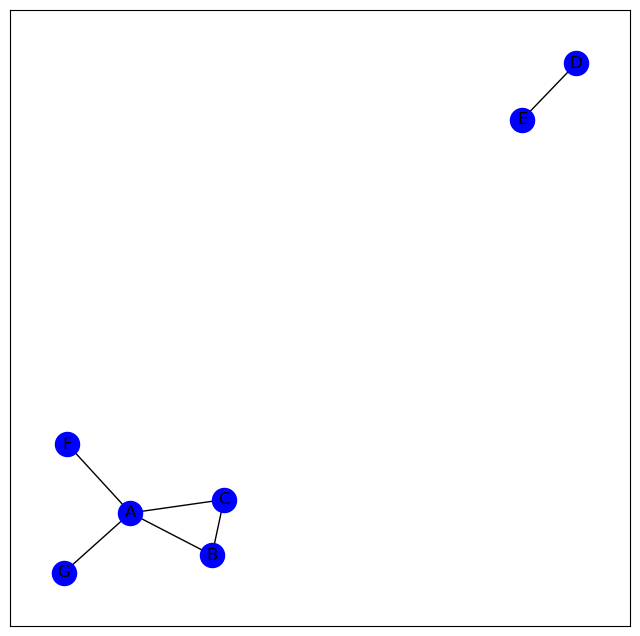

In [ ]:
g_disconnected2 = nx.Graph()
g_disconnected2.add_nodes_from(['A','B','C','D','E','F','G'])
g_disconnected2.add_edges_from([('A','B'),('B','C'), ('C','A'), ('A','F'),('A','G'),('D','E')])
draw_spring(g_disconnected2)

In [ ]:
nx.closeness_centrality(g_disconnected2)

{'A': 0.6666666666666666,
 'B': 0.4444444444444444,
 'C': 0.4444444444444444,
 'D': 0.16666666666666666,
 'E': 0.16666666666666666,
 'F': 0.38095238095238093,
 'G': 0.38095238095238093}

## 3.3 Eigenvector Centrality

Another approach to determine the centrality of a node is to consider how likely it is to reach that node if one would randomly 'walk' through the network. If a node would be reached more frequently than other nodes, this could signal that the node is more central and consequently more relevant. 

Eigenvector centrality is based on this 'random walker' idea. It simulates a random walker moving from node to node, each time with equal probability of going to the adjacent node. The idea is that if the walk goes on for very long, the probability of seeing the walker at a particular node will stabilize, giving you the Eigenvector Centrality value. 

To illustrate, we calculate the Eigenvector Centrality scores for the train stations network. 

In [ ]:
res = nx.eigenvector_centrality(g_trains)
resdf = pd.DataFrame({"station":res.keys(), "score":res.values()})
resdf.set_index("station")
resdf.sort_values('score', ascending=False)

,station,score
1,Utrecht,0.569051
0,Amsterdam,0.389746
9,Groningen,0.267149
15,Zwolle,0.267149
19,Schiphol,0.264338
4,Eindhoven,0.254248
14,The Hague,0.246852
6,Venlo,0.216722
13,Rotterdam,0.174007
7,Nijmegen,0.171231


Recall that degree centrality favors the number of direct neighbors one has, closeness centrality takes into account indirect networks, including thus nodes that are in a "tail" formation behind a node. 

Eigenvector centrality takes into consideration the probabilities that one may move from one appear in one node, and this is a function of how well connected that node is, and also of how well connected the nodes around it are. By virtue of this, one added value of eigenvector centrality is that it takes into consideration the relative importance of nodes. In other words: A node gets a high eigenvector centrality score if it is linked to other nodes which also have a high eigenvector centrality score. Intuitively, consider that "famous" may be defined (at least partly) in terms of having many friends who are also "famous". 

Lets go back to the kite and remember that:
* Degree centrality prefers node 3, and puts node 7 far on the back.
* Closeness prefer both 5 and 6, and puts node 7 in 4th place
Now we will see that
* Eigenvector centrality also prefers node 3, and also puts node 7 far on the back.

Note why this might be so. Node 3 not only has high degree, but it is also close to nodes 5, 6, 0 and 1, which also have high degree. By contrast node 7 is "friends" with 5 and 6, but also with the unpopular 8, so it cannot rank as high.

An advantage of eigenvector centrality (and measures similar to it computationally like pagerank or HITS) is that it relies on matrix multiplications instead of shortest path calculations. Because modern computers are highly optimized to perform matrix multiplications, eigenvector centrality (and similar measures) may perform better in large networks than simpler measures like closeness or betweeness.

<img src="images/shared/kite_generic.png"/>


We can see the scores here.

In [ ]:
degree = nx.degree(g_kite)
nodeid = list(dict(degree).keys())
degscore = list(dict(degree).values())
degcentrality = nx.degree_centrality(g_kite)
degcentscore = list(dict(degcentrality).values())
closenesscent = nx.closeness_centrality(g_kite)
closescores = closenesscent.values()
eigcentrality = nx.eigenvector_centrality(g_kite)
eigscore = list(dict(eigcentrality).values())
reskite3 = pd.DataFrame({"node_id":nodeid, 
                      "degree":degscore, 
                      "deg_centrality":degcentscore,
                         "closeness_cent": closescores,
                        "eig_centrality":eigscore})
reskite3.set_index("node_id", inplace=True)
reskite3.sort_values('eig_centrality', ascending=False)

,degree,deg_centrality,closeness_cent,eig_centrality
node_id,,,,
3,6,0.666667,0.600000,0.481020
5,5,0.555556,0.642857,0.397691
6,5,0.555556,0.642857,0.397691
0,4,0.444444,0.529412,0.352209
1,4,0.444444,0.529412,0.352209
2,3,0.333333,0.500000,0.285835
4,3,0.333333,0.500000,0.285835
7,3,0.333333,0.600000,0.195862
8,2,0.222222,0.428571,0.048075


The mathematics of Eigenvector Centrality are complicated, in particular for non-technical persons. We are not going to present it in full, but we will, in the next example, sketch an idea of how Eigenvector Centrality works and some ways of arriving at it. 

In its simplest form, Eigenvector Centrality is what you get by repeatedly multiplying: 

* an **adjacency matrix** by 
* a **vector of probabilities** associated with each node.

Let us use a small network to illustrate. Imagine we have four nodes "a", "b", "c" and "d", and we are making a network of their linkages. We begin representing this network as a $ 4 \times 4 $ adjacency matrix "A" (it is customary to represent matrices with capital letters). In this matrix a 1 indicates there is a connection between a node in the rows and another in the columns, and a 0 means that there is no connection. If one picks node "a" in the rows, we see that it connects to "b" and "d" in the columns. If we read the row of node "b", we see that it connects with "a" and "d" in the columns. And so on. 

$$ A = \begin{pmatrix}
0 & 1 & 1 & 0 \\ 
1 & 0 & 1 & 1 \\ 
1 & 1 & 0 & 1 \\ 
0 & 1 & 1 & 0 \\ 
\end{pmatrix} $$

For the vector of initial probabilities "v" we can just assume that one is equally likely to be in each of the four rows of the matrix.

$$ v = \begin{pmatrix}{0.25,0.25,0.25,0.25}\end{pmatrix} $$

The basic idea is that if one multiplies "A" and "v" one will "apply" the structure of the contingency matrix to the vector, or "scale" the vector by the matrix. In such multiplication, we will have a transition or "walk" from the equal probability starting point $ v = \begin{pmatrix}{0.25,0.25,0.25,0.25}\end{pmatrix} $ to some other state. If one does this multiple times, updating the value of "v" in every iteration, it is possible that the values will "converge" or stabilize, which means they will not change much from multiplication to multiplication. The now fixed values of v, represent the probability that the random walker will be in a particular row of the matrix (or node of the network) after an indeterminate number of walks. 

In mathematical notation this repeated updating by matrix - vector multiplication may be expressed in this manner (note that $ := $ here emphasizes that we are assigning a value, and not asserting an equality).

$$ v_{i+1}:= Av_{i} $$

This is done for values of $ i = {1, 2, 3, 4, ...} $ until it is the case that the values of $ v $ do not change from multiplication to multiplication. We may express this as an approximate equality because one may be satisfied with very small variations in the score of v, instead of requiring it to be be exactly the same.

$$ v_{i+1} \approx v_{i} $$

Once we are satisfied with the result the vector should be "normalized" by dividing it by its norm. This is done because what interests us is the relative magnitude associated with each node, and not absolute values, which can be very large due to the repeated multiplication (There may be technical reasons to normalize after each iteration of the multiplication, instead of just at the end, this may avoid numbers becoming too large and difficult to calculate).

$$ \frac{v}{||v||} $$

Why is this called Eigenvector Centrality? Because a property of the adjacency matrix, namely, the Eigenvector associated with its highest Eigenvalue, will give the same results as the method presented above.

Let us put the procedure in practice. We first create the adjacency matrix of the kite graph.

In [ ]:
A = nx.adjacency_matrix(g_kite)
A.todense()

array([[0, 1, 1, 1, 0, 1, 0, 0, 0, 0],
       [1, 0, 0, 1, 1, 0, 1, 0, 0, 0],
       [1, 0, 0, 1, 0, 1, 0, 0, 0, 0],
       [1, 1, 1, 0, 1, 1, 1, 0, 0, 0],
       [0, 1, 0, 1, 0, 0, 1, 0, 0, 0],
       [1, 0, 1, 1, 0, 0, 1, 1, 0, 0],
       [0, 1, 0, 1, 1, 1, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]])

The next step is to have an initial vector of probabilities. Each element of this vector should be 1/10 or 0.1. Remember that probabilities have to sum to 1, and if it is equally probable that one may be in each of the 10 nodes of the kite graph, then we have a 0.1 probability for each.

In [ ]:
v = (np.ones(10)/10)
v

array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

Finally we repeatedly multiply the adjacency matrix by the vector of probabilities and normalize the results. We will just do it 100 times. In more complicated scenarios, more repetitions might be required to do the trick. Note that in ```numpy``` the operator ```@``` is used to express matrix multiplication.

After the multiplications are done, we normalize the results by dividing the results vector by its norm.

In [ ]:
for i in range(0,100):
    v = A@v
mynorm = np.linalg.norm(v)
res = v / mynorm
res

array([0.3522094 , 0.3522094 , 0.28583499, 0.48102086, 0.28583499,
       0.39769064, 0.39769064, 0.19586058, 0.04807349, 0.01116326])

NetworkX gives the results directly:


In [ ]:
nx.eigenvector_centrality(g_kite)

{0: 0.35220898139203594,
 1: 0.35220898139203594,
 2: 0.28583473531632414,
 3: 0.48102048812210046,
 4: 0.28583473531632414,
 5: 0.3976910106255469,
 6: 0.3976910106255469,
 7: 0.19586185175360382,
 8: 0.048074775014202945,
 9: 0.01116405857582424}

Finally let us approach it from the perspective of eigenvalues and eigenvectors. 

Eigenvalues and eigenvectors are a property of certain matrices, which often very difficult to get by hand, but which ```numpy``` can provide on command.

Eigenvectors are just vectors, that when multiplied by the matrix ($ matrix \times vector $), scale, but do not rotate. 

Every eigenvector will have an eigenvalue -just a number- associated with it, which records how much the vector is scaled. Here we are interested in the eigenvector that is associated with the largest eigenvalue

The largest eigenvalue here is 4.3. This is in index position 0 of the numpy array (arrays like a python list, start from zero). 

In [ ]:
vals, vecs = np.linalg.eig(A.todense())
vals

array([ 4.30640379,  1.60639741,  1.41421356,  0.64036468, -0.40434195,
       -0.816375  , -2.        , -1.41421356, -1.46406328, -1.86838565])

If we see the eigenvector that is in position 0 (corresponding to the largest eigenvalue that we recall was in index position 0), we again get the result we are looking for. (For all but the smallest networks it can be difficult to visually inspect which value is the largest, here we can use ```numpy.argmax``` to return the position of this value).


In [ ]:
vecs[:,0]

array([0.3522094 , 0.3522094 , 0.28583499, 0.48102086, 0.28583499,
       0.39769064, 0.39769064, 0.19586058, 0.04807349, 0.01116326])

Note what is going on here code wise. ```vecs``` gives us all the eigenvectors. 

In [ ]:
vecs

array([[ 3.52209397e-01,  1.89445487e-01, -3.53553391e-01,
         2.50475739e-01,  5.05030447e-01,  7.62482192e-02,
         5.00000000e-01, -3.53553391e-01,  1.27468135e-01,
        -1.42542367e-02],
       [ 3.52209397e-01,  1.89445487e-01,  3.53553391e-01,
         2.50475739e-01,  5.05030447e-01,  7.62482192e-02,
        -5.00000000e-01,  3.53553391e-01,  1.27468135e-01,
        -1.42542367e-02],
       [ 2.85834991e-01,  1.16760682e-01, -5.00000000e-01,
         9.77805840e-02, -3.42822530e-01, -3.38990557e-01,
        -9.34646417e-16,  5.00000000e-01,  4.02146483e-01,
        -3.06688753e-02],
       [ 4.81020858e-01,  1.68769387e-01, -7.50920951e-18,
         1.21495199e-01, -2.55950827e-01, -1.05180509e-01,
         6.94235091e-16,  1.19307444e-15, -6.96430792e-01,
         4.04703757e-01],
       [ 2.85834991e-01,  1.16760682e-01,  5.00000000e-01,
         9.77805840e-02, -3.42822530e-01, -3.38990557e-01,
         1.75730461e-16, -5.00000000e-01,  4.02146483e-01,
        -3.

Each of the eigenvectors (associated with every eigenvalue) is in a column. Using ```vecs[:,0]``` tell us "give me all the rows, under column zero.

In [ ]:
vecs[:,0]

array([0.3522094 , 0.3522094 , 0.28583499, 0.48102086, 0.28583499,
       0.39769064, 0.39769064, 0.19586058, 0.04807349, 0.01116326])

## 3.4 PageRank

PageRank is a variant of the Eigenvector centrality which is applicable to directed networks. Like Eigenvector Centrality it considers not only the ammount of links one receives, but also the popularity of those linking to us. It is also based on the "random walk idea": the pagerank score corresponds to the likelihood of a user ending up on that page by randomly clicking from link to link. PageRank used to form the basis for the Google search engine algorithm. Here we can see how it might work in a simplified citation network of the American case Obergefell v. Hodges.

<img src="images/ch3/obergefell.png"/>


In [ ]:
g_ob = load_graph_from_json("data/obergefell.json")
resdict = nx.pagerank(g_ob, alpha=0.90)
pd.DataFrame.from_dict(resdict, orient="index", columns=["pagerank_score"])


,pagerank_score
Obergefell_v_Hodges,0.039186
Lawrence_v_Texas,0.043595
Bowers_v_Hardwick,0.043595
Zablocki_v_Redhail,0.043595
Turner_v_Safley,0.043595
Windsor_v_United_States,0.043595
PPvCasey,0.052265
Roe_v_Wade,0.062706
Griswold_v_Connecticut,0.085926
Lochner_v_New_York,0.057998


PageRank incorporates a "teleportation" factor: As a random walker moves through the network, it may get stuck on a node or nodes that has only incoming links to it, and no outgoing links. For example, Loving v. Virginia or Lochner v. New York. The teleportation factors implies a random chance of teleporting anywhere else in the network and thus avoiding such dead ends.


To correct for this, the standard pagerank model gives a small random percentage of "teleporting" to any node in the network. The default value for this in NetworkX is 0.15. 

The details are as follows: 

The first thing PageRank needs, is to transform the adjacency matrix into a transition matrix. While an adjacency matrix will record a 1 if there is a connection between a node in the rows and a node in the column, the transition matrix will record the probability of jumping from a node in the rows to another one in the columns in such a way that the probabilities all sum to 1. 

Imagine once more we have four metro stations A, B, C, D, that are connected as follows:

$$ A = \pmatrix{
0 & 1 & 0 & 1 \\ 
1 & 0 & 0 & 1 \\ 
1 & 1 & 0 & 1 \\ 
0 & 1 & 1 & 0 \\ 
} $$

If we are in station A (first row), we can jump to station B or D. If we are in station B (second row) we can jump to station A and D. Granting equal probability of making that jump, we now weight the connection in terms of probabilities as in this manner:

$$ T = \pmatrix{
0 & 0.5 & 0 & 0.5 \\ 
0.5 & 0 & 0 & 0.5 \\ 
\frac{1}{3} & \frac{1}{3} & 0 & \frac{1}{3} \\ 
0 & 0.5 & 0.5 & 0 \\ 
} $$

Note that each row will sum to 1 as per the rules of probability.

Just like with Eigenvector centrality, the next thing needed is a vector that reflects the probability of being in each of the nodes of the network. There are four nodes, so a vector with equal probability will be a vector of 0.25s.

$$ v = \pmatrix{
0.25 & 0.25 & 0.25 & 0.25 \\ 
} $$

In principle what needs to be done next is to multiply the vector of probabilities by the transition matrix many times. 

$$ v := T^T \times v $$

However, if this algorithm is used, nodes that are sinks (have no outgoing links) or which form a closed circuit will trap all the pagerank scores. So something needs to be changed. What happens is that the transition matrix T is modified by adding a teleportation factor Beta to it, so that for every node there is a 1-Beta chance of getting out. It is standard to put Beta at 0.85. 

In NetworkX the transition matrix so modified is called the google matrix, and so we are going to denote it with the letter G.

$$ G = T * Beta + [(1-Beta)/n]_{nxn} $$

Now we can go ahead and repeatedly multiply G and the vector of probabilities.

$$ v := G^T \times v $$

Just like with Eigenvector Centrality, eventually the values of v will not change much from multiplication to multiplication, leading us to our score (unnormalized).

Pagerank is presented as a percentage, so then we normalize this value by dividing it for its sum:

$$ pagerank = \frac{v}{\sum v} $$


This is how we can get the scores using a for loop.

In [ ]:

A = nx.google_matrix(g_ob).T
v = np.ones(16)/16

for i in range(0, 100):
    v = A @ v.reshape(16,-1)
    vnorm = np.linalg.norm(v)
    v = v/vnorm

result = np.ravel(v/sum(v))
    


In [ ]:
official_pr = nx.pagerank(g_ob)
resdf = pd.DataFrame({"nodes":official_pr.keys(), "official": official_pr.values(), "unofficial":result})
resdf.set_index("nodes")

,official,unofficial
nodes,,
Obergefell_v_Hodges,0.040254,0.040254
Lawrence_v_Texas,0.044531,0.044531
Bowers_v_Hardwick,0.044531,0.044531
Zablocki_v_Redhail,0.044531,0.044531
Turner_v_Safley,0.044531,0.044531
Windsor_v_United_States,0.044531,0.044531
PPvCasey,0.052871,0.052871
Roe_v_Wade,0.062724,0.062724
Griswold_v_Connecticut,0.084773,0.084773


And as expected, the eigenvalues associated with the largest eigenvector give us the same result.

In [ ]:
A = nx.google_matrix(g_ob).T
vals, vecs = np.linalg.eig(A)
argmax = np.argmax(vals)
eigresult = np.ravel(vecs[:,argmax])
eigresult = eigresult/np.sum(eigresult)


In [ ]:
pd.DataFrame({"nodes":official_pr.keys(), "official": official_pr.values(), "unofficial":result, "eigen":eigresult}).set_index("nodes")

,official,unofficial,eigen
nodes,,,
Obergefell_v_Hodges,0.040254,0.040254,0.040254+0.000000j
Lawrence_v_Texas,0.044531,0.044531,0.044531+0.000000j
Bowers_v_Hardwick,0.044531,0.044531,0.044531+0.000000j
Zablocki_v_Redhail,0.044531,0.044531,0.044531+0.000000j
Turner_v_Safley,0.044531,0.044531,0.044531+0.000000j
Windsor_v_United_States,0.044531,0.044531,0.044531+0.000000j
PPvCasey,0.052871,0.052871,0.052871+0.000000j
Roe_v_Wade,0.062724,0.062724,0.062724+0.000000j
Griswold_v_Connecticut,0.084773,0.084773,0.084773+0.000000j


## 3.5 Betweenness Centrality

So far we have been thinking of centrality in relation to the number of neighbors a node has. 
1. Degree centrality simply focuses on the number of direct neighbors a node has.
2. Closeness centrality takes into account not just direct neighbors, but also indirectly linked nodes.
3. Eigenvector centrality and Pagerank consider the connectedness or "fame" of the neighbors.

Now we will introduce a different focus. We will consider as most important not just nodes that have a lot of neighbors, but nodes that are "mediators", or "brokers" in the network. These are nodes that hold the network together. If they are deleted, this will cause severe disruption in the network, possibly disconnecting parts of the network. Betweenness centrality considers this broker status. To illustrate how betweenness centrality can be determined or explained, we start with the example of actual political brokerage. The "Florentine Families" graph is a study of marriage alliances between families in Renaissance Florence. However, the visualization of the graph does not immediately allow us to see the dominance of the Medici.

<img src="images/shared/florentine_generic.png"/>


Conventional centrality measures will show that the Medici have a stronger political situation, but they are not really dominant. The closeness score for Medici is 0.0899, but Strozzi, Barbadori, Ridolfi, Tornabuouni, Albizzi and Guadagni are not far behind. Once we factor in betweenness, the scores for the aforementioned families drop significantly and we get far better impression of the dominance of the Medici.

In [ ]:
closeness_arr = np.array([x for x in nx.closeness_centrality(g_florentine).values()])
closeness_sum = np.sum(closeness_arr)
closeness_norm = closeness_arr/closeness_sum
betweenness_arr = np.array([x for x in nx.betweenness_centrality(g_florentine).values()])
betweenness_sum = np.sum(betweenness_arr)
betweenness_norm = betweenness_arr/betweenness_sum


df_medici = pd.DataFrame({'families':nx.closeness_centrality(g_florentine).keys(), 
                       'closeness_norm': closeness_norm,
                      'betweenness_norm': betweenness_norm})
df_medici

,families,closeness_norm,betweenness_norm
0,Acciaiuoli,0.059170,0.000000
1,Medici,0.089939,0.304487
2,Castellani,0.062458,0.032051
3,Peruzzi,0.059170,0.012821
4,Strozzi,0.070265,0.059829
5,Barbadori,0.070265,0.054487
6,Ridolfi,0.080303,0.066239
7,Tornabuoni,0.077534,0.053419
8,Albizzi,0.077534,0.123932
9,Salviati,0.062458,0.083333


Here we can see the massive contrast. The blue bars highlight the closeness centrality, and the red bars betweenness centrality. (If a blue bar exceeds a red bar, this indicates the extent to which the closeness centrality score is higher than the betweenness centrality score.)

<Axes: xlabel='betweenness_norm', ylabel='families'>

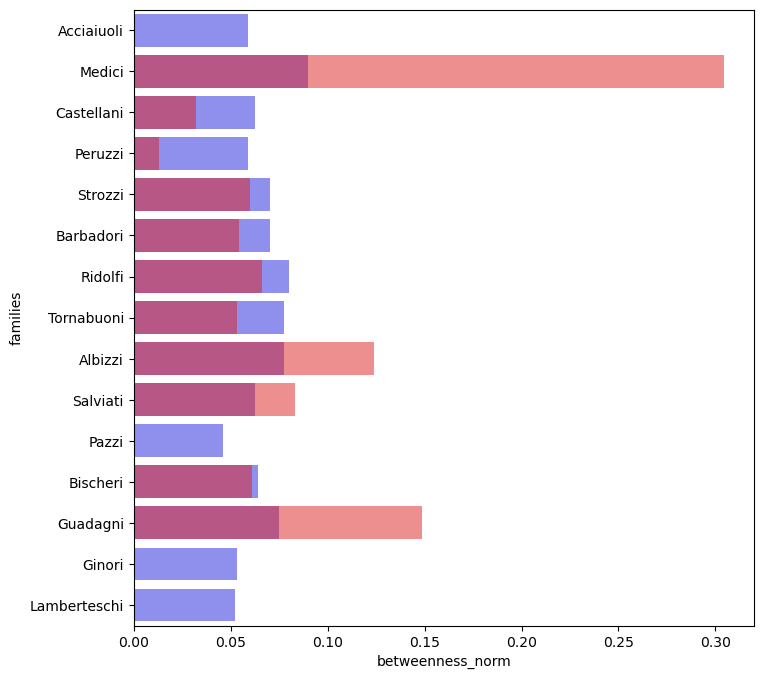

In [ ]:
plt.figure(figsize=(8,8))
sns.barplot(y = df_medici.families, x = df_medici.closeness_norm, color='blue', alpha =0.5)
sns.barplot(y = df_medici.families, x = df_medici.betweenness_norm, color='red', alpha = 0.5)

Finally, let's see what happens when we remove the Medici family from the graph. As we can see, the graph suddenly becomes disconnected.

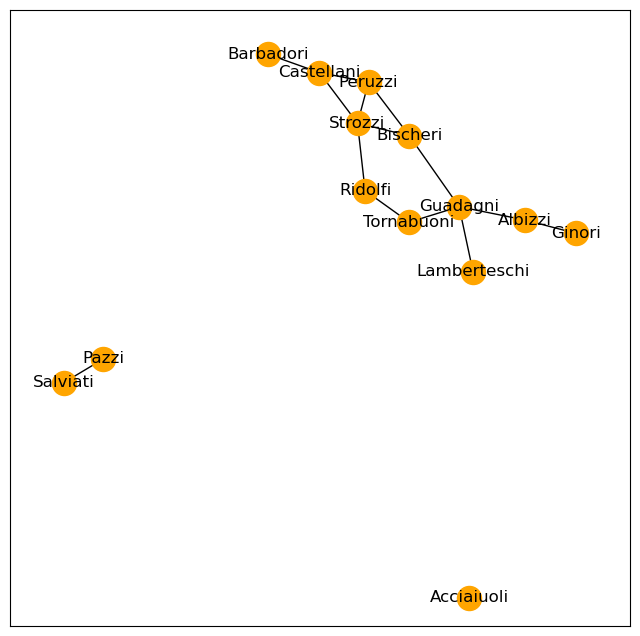

In [ ]:
g_subflorentine = g_florentine.subgraph([x for x in g_florentine.nodes if not x=="Medici"])
draw_spring(g_subflorentine, node_color="orange")

We can perform a similar analysis for the subgraph of our CJEU case law network. We start with a comparison between the closeness and betweenness centrality scores of the cases. We first display the network.

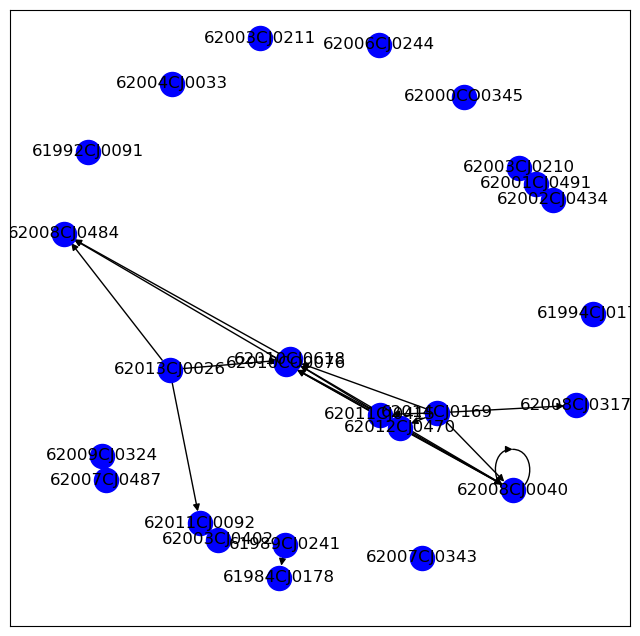

In [22]:
g_consprot2 = load_graph_from_json("data/g_consprot2.json")
draw_spring(g_consprot2)

Like in the Medici family example, we compare the closeness and betweenness centrality scores...

In [ ]:
closeness_arr = np.array([x for x in nx.closeness_centrality(g_consprot2).values()])
closeness_sum = np.sum(closeness_arr)
closeness_norm = closeness_arr/closeness_sum
betweenness_arr = np.array([x for x in nx.betweenness_centrality(g_consprot2).values()])
betweenness_sum = np.sum(betweenness_arr)
betweenness_norm = betweenness_arr/betweenness_sum


df_consprot = pd.DataFrame({'cases':nx.closeness_centrality(g_consprot2).keys(), 
                       'closeness_norm': closeness_norm,
                      'betweenness_norm': betweenness_norm})
df_consprot

,cases,closeness_norm,betweenness_norm
0,62008CJ0040,0.205323,0.000000
1,62009CJ0324,0.000000,0.000000
2,61994CJ0178,0.000000,0.000000
3,62010CO0076,0.142586,0.214286
4,61989CJ0241,0.000000,0.000000
5,62013CJ0026,0.000000,0.000000
6,61984CJ0178,0.039924,0.000000
7,62004CJ0033,0.000000,0.000000
8,62012CJ0470,0.039924,0.047619
9,62001CJ0491,0.079848,0.000000


... and we visualize for each decision their closeness centrality (blue bars) and betweenness centrality (red bars) scores. From the visualization we can infer that the decision which has the highest 'broker' score also has a high closeness centrality score, and that decisions with a high closeness centrality score do not necessarily have a high betweenness centrality.

<Axes: xlabel='betweenness_norm', ylabel='cases'>

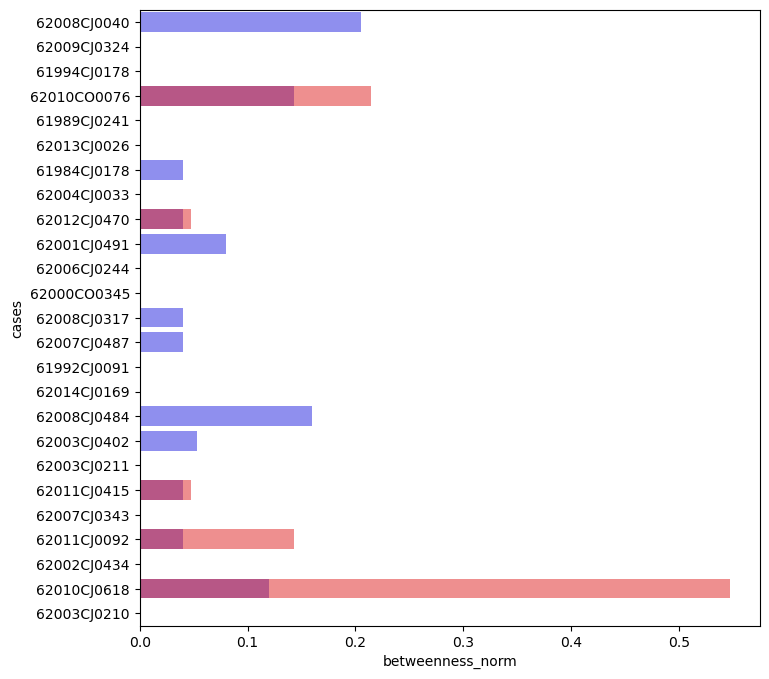

In [ ]:
plt.figure(figsize=(8,8))
sns.barplot(y = df_consprot.cases, x = df_consprot.closeness_norm, color='blue', alpha =0.5)
sns.barplot(y = df_consprot.cases, x = df_consprot.betweenness_norm, color='red', alpha = 0.5)

The case with CELEX number C2010CJ0618 is hte decision with the highest betweenness centrality score. Removing these decisions, like in the Medici family example, significantly changes the structure of the network.

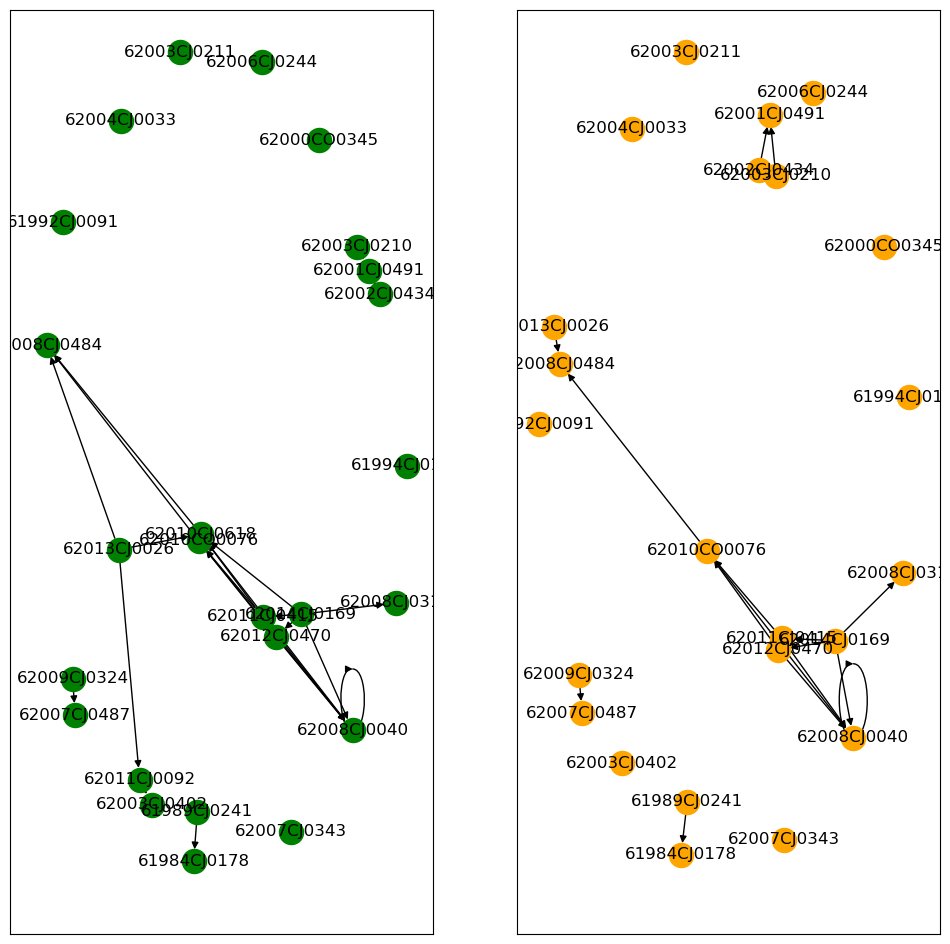

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,12))

pos = nx.spring_layout(g_consprot2, seed =123)
nx.draw_networkx_nodes(g_consprot2, pos=pos, node_color="green", ax=ax[0])
nx.draw_networkx_edges(g_consprot2, pos=pos, ax=ax[0])
nx.draw_networkx_labels(g_consprot2, pos=pos, ax=ax[0])

g_consprot3 = g_consprot2.subgraph([x for x in g_consprot2.nodes if x not in ["62010CJ0618", "62010CJ0076", "62011CJ0092"]])
pos = nx.spring_layout(g_consprot3, seed =123)
nx.draw_networkx_nodes(g_consprot3, pos=pos, node_color="orange", ax=ax[1])
nx.draw_networkx_edges(g_consprot3, pos=pos, ax=ax[1])
nx.draw_networkx_labels(g_consprot3, pos=pos, ax=ax[1]);

How can betweenness centrality be explained in more mathematical terms? Betweenness centrality focuses on the number of shortest paths that pass through a node v. First take any pair of nodes s, t. We can obtain the length of all the shortest paths between s and t using a shortest path function that we here call 'spath'.

$$ spath(s, t) $$

We can also get the length of all the shortest paths between s and t that pass through our node of interest, v.

$$ spaths(s, t \mid v) $$ 
(The bar there just says "on condition that they pass through v".)

Subsequently we can calculate the proportion or ratio of shortest paths that pass through v compared to the total number of shortest paths:

$$ \frac{spaths(s, t \mid v)}{spath(s, t)} $$

This will do it for a pair of nodes s, t. But we need to do this for every pair of nodes s, t, and sum the results:

$$ \sum_{s,t \in V} \frac{spaths(s, t \mid v)}{spath(s, t)} $$
(The $ \Sigma $ is effectively saying, "do this for every pair of nodes s, t in V, adding up the results along the way".)

## 3.6 Hyperlink-Induced Topic Search (HITS)

HITS is an algorithm for identifying centrality in directed networks. It produces two scores:

* The authority score keeps track of how effective are nodes in receiving citations or references from other nodes. 

* The hub score keeps track how effective are nodes in making citations to other nodes.

So far this may look like in-degree and out-degree. The key difference is that the HITS algorithm does not merely count neighbors, but like Eigenvector Centrality and PageRank works recursively. A node receives a high hub score by citing  highly ranked authorities and a high authority score by being cited by highly ranked hubs and these scores are updated progressively through various iterations. 

Below we apply the algorithm to the obergefell network and we can see what one should expect, that Obergefell is the key hub, and that Loving v. Virginia the key authority. NetworkX provides us with the option of returning HITS results normalized or unnormalized. The normalized results are clearly more informative. Normalization here means showing each score as the proportion of the total scores, so that the scores would sum to 1 (or function as a percentage if multiplied by a 100). Appendix 3 provides more insight into normalization.

In [24]:
results = nx.hits(g_ob, normalized=False)
results_n = nx.hits(g_ob, normalized=True)
hubs = results[0]
authorities = results[1]
hubs_n = results_n[0]
authorities_n = results_n[1]
df_hits = pd.DataFrame({'nodes':hubs.keys(),
                   'hubs': [np.round(x,2) for x in hubs.values()],
                  'authorities': [np.round(x,2) for x in authorities.values()],
                  'hubs_normalized': [np.round(x,2) for x in hubs_n.values()],
                   "authorities_normalized": [np.round(x,2) for x in authorities_n.values()]})
df_hits

,nodes,hubs,authorities,hubs_normalized,authorities_normalized
0,Obergefell_v_Hodges,-2.77,0.00,0.53,0.00
1,Lawrence_v_Texas,0.00,-0.31,0.00,0.11
2,Bowers_v_Hardwick,0.00,-0.31,-0.00,0.11
3,Zablocki_v_Redhail,-0.47,-0.31,0.09,0.11
4,Turner_v_Safley,-0.47,-0.31,0.09,0.11
5,Windsor_v_United_States,-0.47,-0.31,0.09,0.11
6,PPvCasey,-0.48,0.00,0.09,0.00
7,Roe_v_Wade,-0.55,-0.05,0.11,0.02
8,Griswold_v_Connecticut,-0.00,-0.43,-0.00,0.15
9,Lochner_v_New_York,0.00,-0.06,-0.00,0.02


Like Eigenvector centrality, HITS is an iterative algorithm that can be represented in many ways. Here, we will present one option that uses repeated multiplication on a modified version of the adjacency matrix. For this, let us first get the adjacency matrix of our graph.

Note that because this is a directed network the adjacency matrix is not symmetrical.

In [25]:
Ad = nx.adjacency_matrix(g_ob).todense()
Ad

array([[0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

Now we have to scale the adjacency matrix by the transpose of itself. Transposition here just swaps the order of rows and columns. We call this new matrix M.

$$ M = Ad^T \times Ad $$

In numpy code this is represented in this manner:

In [26]:
M = Ad.T@Ad
M

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0],
       [0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0],
       [0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0],
       [0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0],
       [0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 1, 1, 0, 1, 3, 1, 0, 1, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0],
       [0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 4, 1, 0, 0],
       [0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1]])

Unlike the Adjacency matrix for a directed network, this M matrix is symmetrical. This implies that the resulting network is bidirectional or undirected even if the original network was directed. This further implies that there is less reason to worry about a random walker being trapped, and hence no need for the teleportation strategy used in PageRank.

Now that we have M, we are going to simulate the repeated scaling of a set of initial values by M, just like with did with Eigenvector Centrality. Since we have a 16x16 matrix, we are going to create a vector x with 16 initial values of 0.0625.

$$ x = [0.0625, 0.0625, 0.0625, 0.0625 ... ] $$



In order to get the authority score, we repeatedly multiply the new matrix M with the vector of probabilities x like we did before in Eigenvector Centrality and PageRank. After many repetitions, the values of x stabilize giving us the unnormalized result.

In [92]:
x = (np.ones(16)/16)
for i in range(0,100):
    x = M@x.reshape(16,1)
    mynorm = np.linalg.norm(x)
    x = x/mynorm
np.round(x,2)

array([[0.  ],
       [0.31],
       [0.31],
       [0.31],
       [0.31],
       [0.31],
       [0.  ],
       [0.05],
       [0.43],
       [0.06],
       [0.  ],
       [0.06],
       [0.47],
       [0.31],
       [0.  ],
       [0.  ]])

Now let's get the hubs scores. For these we are going to first get a matrix N that is produced by multiplying the adjacency matrix by itself tranposed (if you think of multiplication in algebra, this procedure may appear identical to the one we used to get the matrix M. Multiplication is normally commutative, that is to say $ 3 \times 4 $ is the same as $ 4 \times 3 $ However matrix multiplication is not commutative. 

$$ N = Ad \times Ad^T $$

Since we have a 16x16 matrix, we are going to create a vector y with 16 initial values of 0.0625, exactly the same as we did for x above.

$$ x = [0.0625, 0.0625, 0.0625, 0.0625 ... ] $$


In [86]:
y = (np.ones(16)/16)
for i in range(0,100):
    y = N@y.reshape(16,1)
    mynorm = np.linalg.norm(y)
    y = y/mynorm
np.round(y,2)

array([[0.93],
       [0.  ],
       [0.  ],
       [0.16],
       [0.16],
       [0.16],
       [0.16],
       [0.19],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ]])

Now you will see that the unnormalized scores presented here seem to bear no relation to the unnormalized scores produced by NetworkX. This is not significant, and it is simply a byproduct of the process by which these results were obtained. After normalization, the results converge exactly. First we proceed to normalize.

In [93]:
sumx = np.sum(x)
myauth_norm = x/sumx
myauth_norm = np.round(myauth_norm,2)

sumy = np.sum(y)
myhubs_norm = y/sumy
myhubs_norm = np.round(myhubs_norm,2)

And now compare the results by adding them to the table we created at the beginning of this section

In [94]:
df_hits['my_hubs_norm'] = myhubs_norm
df_hits['my_auth_norm'] = myauth_norm
df_hits

,nodes,hubs,authorities,hubs_normalized,authorities_normalized,my_hubs_norm,my_auth_norm
0,Obergefell_v_Hodges,-2.77,0.00,0.53,0.00,0.53,0.00
1,Lawrence_v_Texas,0.00,-0.31,0.00,0.11,0.00,0.11
2,Bowers_v_Hardwick,0.00,-0.31,-0.00,0.11,0.00,0.11
3,Zablocki_v_Redhail,-0.47,-0.31,0.09,0.11,0.09,0.11
4,Turner_v_Safley,-0.47,-0.31,0.09,0.11,0.09,0.11
5,Windsor_v_United_States,-0.47,-0.31,0.09,0.11,0.09,0.11
6,PPvCasey,-0.48,0.00,0.09,0.00,0.09,0.00
7,Roe_v_Wade,-0.55,-0.05,0.11,0.02,0.11,0.02
8,Griswold_v_Connecticut,-0.00,-0.43,-0.00,0.15,0.00,0.15
9,Lochner_v_New_York,0.00,-0.06,-0.00,0.02,0.00,0.02


Alternatively, if we have the authority scores, we can just scale them by the adjacency matrix to get the hubs scores

In [124]:
y = Ad@x
y

array([[2.77113276e+00],
       [7.24312290e-48],
       [0.00000000e+00],
       [4.70982908e-01],
       [4.70982908e-01],
       [4.70982908e-01],
       [4.82905949e-01],
       [5.53057810e-01],
       [4.68467134e-96],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00]])

Now normalized:

In [125]:
np.round(y/np.sum(y), 2)


array([[0.53],
       [0.  ],
       [0.  ],
       [0.09],
       [0.09],
       [0.09],
       [0.09],
       [0.11],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ]])

For yet one more way to calculate the HITS score, remember that repeated multiplication is connected to eigenvectors, so here we can see that an alternative way to get the same result is to get the eigenvectors corresponding to the largest eigenvalue of M.

In [103]:
vals, vecs = np.linalg.eig(M)
vals

array([-2.22044605e-16+0.00000000e+00j,  3.00000000e+00+0.00000000e+00j,
        8.88372254e+00+0.00000000e+00j,  3.44992335e+00+0.00000000e+00j,
        2.31089374e+00+0.00000000e+00j,  1.35546037e+00+0.00000000e+00j,
       -1.86689873e-16+0.00000000e+00j,  2.08806008e-16+0.00000000e+00j,
        1.75741997e-16+0.00000000e+00j,  3.14921698e-17+1.33634819e-16j,
        3.14921698e-17-1.33634819e-16j, -1.08093785e-17+0.00000000e+00j,
       -1.23711981e-18+0.00000000e+00j,  2.54169549e-33+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j,  1.00000000e+00+0.00000000e+00j])

The largest eigenvalue is in position 2.

In [104]:
np.argmax(vals)

2

And this is just our result for the authority score not normalized. 



In [105]:
a = vecs[:,2]
np.round(a,2)



array([ 0.  +0.j,  0.31+0.j,  0.31+0.j,  0.31+0.j,  0.31+0.j,  0.31+0.j,
       -0.  +0.j,  0.05+0.j,  0.43+0.j,  0.06+0.j,  0.  +0.j,  0.06+0.j,
        0.47+0.j,  0.31+0.j, -0.  +0.j, -0.  +0.j])

After normalization it is the same as the authority score normalized.

In [106]:
sum_a = np.sum(a)
myauth_norm2 = a/sum_a
np.round(myauth_norm2,2)


array([ 0.  +0.j,  0.11+0.j,  0.11+0.j,  0.11+0.j,  0.11+0.j,  0.11+0.j,
       -0.  +0.j,  0.02+0.j,  0.15+0.j,  0.02+0.j,  0.  +0.j,  0.02+0.j,
        0.16+0.j,  0.11+0.j, -0.  +0.j, -0.  +0.j])

If we multiply the adjacency matrix for this we can get the hubs score

In [107]:
h = Ad@a
h = np.round(h, 2)
h

array([ 2.77+0.j, -0.  +0.j,  0.  +0.j,  0.47+0.j,  0.47+0.j,  0.47+0.j,
        0.48+0.j,  0.55+0.j,  0.  +0.j,  0.  +0.j,  0.  +0.j,  0.  +0.j,
        0.  +0.j,  0.  +0.j,  0.  +0.j,  0.  +0.j])

...and then normalize to end up in the same place through direct application of eigenvectors.

In [108]:
sum_h = np.sum(h)
myhubs_norm2 = h/sum_h
np.round(myhubs_norm2,2)


array([0.53+0.j, 0.  +0.j, 0.  +0.j, 0.09+0.j, 0.09+0.j, 0.09+0.j,
       0.09+0.j, 0.11+0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j,
       0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j])

The advantages and disadvantages of this or that procedure for getting the results will not be discussed here.

## 3.7 Comparing Centrality Scores

To conclude this section, it is worth reflecting on the value of different centrality measures. As has been noted above, there is a significant degree of judgment needed to determine which centrality measure is the best for each case. 

It may be valuable to look at centrality measures together in order to ascertain where things stand. Here we provide a simple analysis that includes the degree of correlation between the measures. 

Normally one would expect all measures to be positively correlated (being more central in one way, makes one more central in other ways, even if perhaps not to the same intensity. However this will not always be the case. 

If we see that measures are negatively correlated (as is the case for eigenvector centrality and betweenness centrality in the kite graph) we learn something important about the graph structure, for example, that the graph is easy to separate as the network brokers have themselves limited degree of connections.


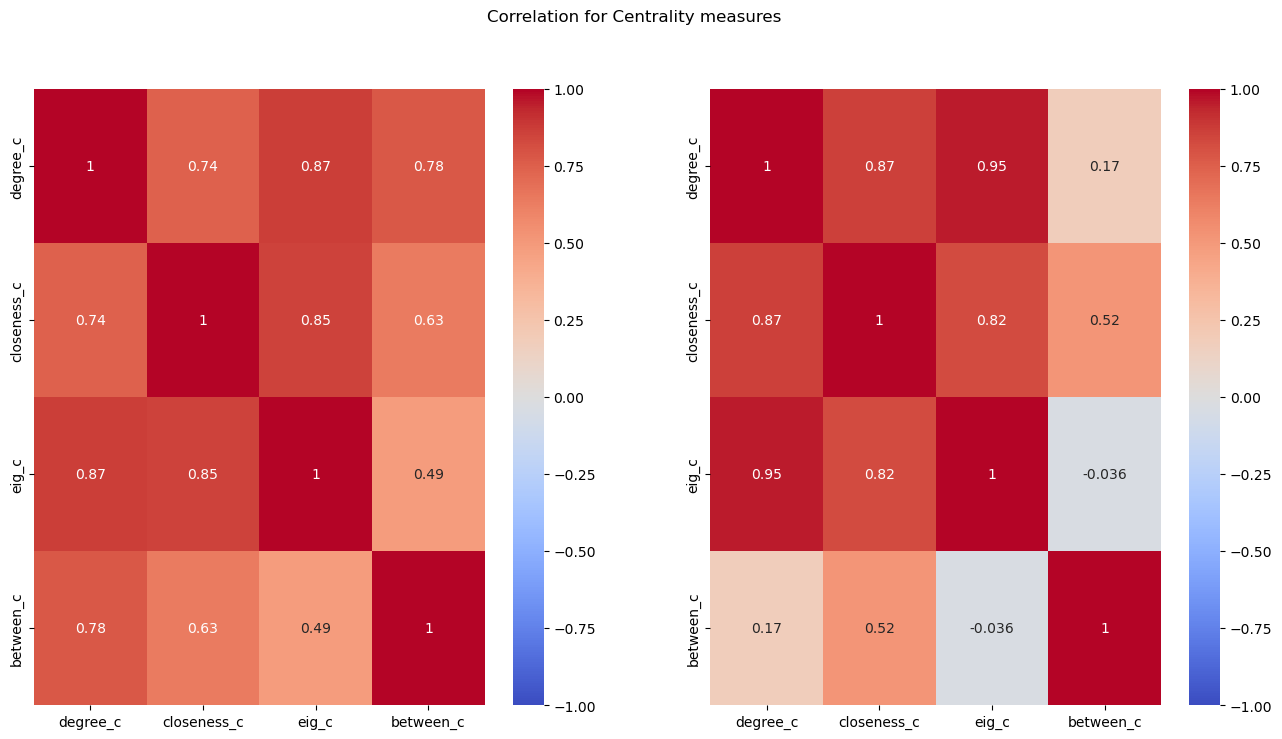

In [121]:
g_trains = load_graph_from_json("data/g_trains.json")
g_kite = nx.krackhardt_kite_graph()
results_trains = []
for i in [nx.degree_centrality, nx.closeness_centrality, nx.eigenvector_centrality, nx.betweenness_centrality]:
    res = i(g_trains)
    results_trains.append(res)

comparision_trains = pd.DataFrame({"nodes":results_trains[0].keys(), 
              "degree_c":results_trains[0].values(),
             "closeness_c":results_trains[1].values(),
              "eig_c":results_trains[2].values(),
              "between_c":results_trains[3].values()})
comparision_trains.set_index("nodes", inplace=True)

results_kite = []
for i in [nx.degree_centrality, nx.closeness_centrality, nx.eigenvector_centrality, nx.betweenness_centrality]:
    res = i(g_kite)
    results_kite.append(res)

comparision_kite = pd.DataFrame({"nodes":results_kite[0].keys(), 
              "degree_c":results_kite[0].values(),
             "closeness_c":results_kite[1].values(),
              "eig_c":results_kite[2].values(),
              "between_c":results_kite[3].values()})
comparision_kite.set_index("nodes", inplace=True)


fig, ax = plt.subplots(1,2, figsize=[16,8])
plt.suptitle("Correlation for Centrality measures")
sns.heatmap(comparision_trains.corr(), annot=True, vmin=-1, vmax=1, cmap="coolwarm", ax=ax[0])
sns.heatmap(comparision_kite.corr(), annot=True, vmin=-1, vmax=1, cmap="coolwarm", ax=ax[1]);

